In [1]:
import numpy as np
from scipy.linalg import expm as expMatrix

def get_sigmaE(vectorX, vectorW):
    """
        Multiplies the input (vectorX) by the weights (vectorW), resulting in a diagonal matrix. 
        It discards any imaginary part vectorX and vectorW might have.
        Equivalent of Equation #17 in the Article.
    """
    n = len(vectorX)
    sigmaE = np.zeros((n,n))
    for i in range(n):
        sigmaE[i,i] = np.real(vectorX[i])*np.real(vectorW[i])

    return sigmaE

def get_sigmaQ(n):
    """
        Sums sigmaX, sigmaY and sigmaZ to get sigmaQ.
        - sigmaX comes from Equation #7 = [0, 1   1, 0]
        - sigmaY comes from Equation #8 = [0, -i  i, 0]
        - sigmaZ comes from Equation #9 = [1, 0   0, -1]
        Equivalent of Equation #16 in the Article.
    """
    sigmaQ = np.zeros((n,n))
    sigmaX = np.array([[0,1], [1,0]])
    sigmaY = np.array([[0,-1j], [1j,0]])
    sigmaZ = np.array([[1,0], [0,-1]])
    sigmaQ = sigmaX + sigmaY + sigmaZ

    return sigmaQ

def get_sigmaQ_param(n, param):
    """
        Sums sigmaX, sigmaY and sigmaZ to get sigmaQ.
        - sigmaX comes from Equation #7 = [0, 1   1, 0]
        - sigmaY comes from Equation #8 = [0, -i  i, 0]
        - sigmaZ comes from Equation #9 = [1, 0   0, -1]
        Equivalent of Equation #16 in the Article.
    """
    sigmaQ = np.zeros((n,n))
    sigmaX = np.array([[0,1], [1,0]])
    sigmaY = np.array([[0,-1j], [1j,0]])
    sigmaZ = np.array([[1,0], [0,-1]])
    sigmaH = np.array([[1,1],[1,-1]])*(1/np.sqrt(2))
    sigmaQ = param[0]*sigmaX + param[1]*sigmaY + param[2]*sigmaZ + param[3]*sigmaH

    return sigmaQ


def get_U_operator(sigmaQ, sigmaE):
    """
        Makes the exponential matrix of tensor product between sigmaQ and sigmaE and multiplies it by j. 
        Equivalent of Equation #15 in the Article.
    """
    sigmaQ[np.isnan(sigmaQ)] = 0
    sigmaE[np.isnan(sigmaE)] = 0
    return np.matrix(expMatrix(1j*np.kron(sigmaQ, sigmaE)))

def get_p(psi):
    """
        Creates a matrix out of psi and multiply it against its inverse, 
        resulting in a column vector in the form [[alfa]. [beta]].
        Does the operation |psi><psi| from Equation #18 or #19 in the Article.
    """
    psi = np.matrix(psi)
    return psi * psi.getH()

def create_and_execute_classifier(vectorX, vectorW, normalizeX=False, normalizeW=False):
    """
        Applies the ICQ classifier using only the math behind the Quantum Classifier 
        described in Interactive Quantum Classifier Inspired by Quantum Open System Theory
        article. 
        After doing so, it gets the result of Equation #20 and returns Z as the predicted class and
        the probability of being the class 1.
        Works only for binary classifications, therefore, if the probability of class 0 is needed, it can
        be 1 - probability of being class 1.
    """
    global params
    
        
    if normalizeX:
        vectorX = normalize(vectorX)
    if normalizeW:
        vectorW = normalize(vectorW)
        
    # Eq #16
    #sigmaQ = get_sigmaQ(2)
    sigmaQ = get_sigmaQ_param(2, params)

    # Eq #17
    sigmaE = get_sigmaE(vectorX, vectorW)

    # Eq #15
    U_operator = get_U_operator(sigmaQ, sigmaE)

    # Eq #18 applied on a Quantum state equivalent of Hadamard(|0>) = 1/sqrt(2) * (|0> + |1>) 
    p_cog = get_p([[1/np.sqrt(2)],[1/np.sqrt(2)]])

    # As we must have 1 row per attribute of the input, we need env to be as big as one instance of our input
    N = len(vectorX)

    # Eq #19 applied on a Quantum state equivalent of Hadamard(|000000...>) = 1/sqrt(N) * (|000000...> + ... + |11111111....>) 
    p_env = get_p([[1/np.sqrt(N)] for i in range(N)])

    # First part of Equation #20 in the Article
    quantum_operation = np.array(U_operator * (np.kron(p_cog, p_env)) * U_operator.getH())

    # Second part of Equation #20 in the Article
    p_cog_new = np.trace(quantum_operation.reshape([2,N,2,N]), axis1=1, axis2=3)

    # As the result is a diagonal matrix, the probability of being class 0 will be on position 0,0
    p_cog_new_00_2 = p_cog_new[0,0]

    # ... and the probability of being class 1 will be on position 1,1
    p_cog_new_11_2 = p_cog_new[1,1]
    if (p_cog_new_00_2 >= p_cog_new_11_2):
        z = 0
    else:
        z = 1
    return z, p_cog_new_11_2, U_operator

def update_weights(weights, y, z, x, p, n):
  """
    Updates the weights. Equation #34 in the Article.
    
    y is the expected classification [0, 1];
    z is the actual classification [0, 1];
    x is the attribute vector;
    p is the probability of the class 1 (0, 1), powered to 2 (p²);
    n is the learning rate.
  """
  # Eq 33
  loss_derivative_on_weight = (1-p)*x

  # Eq 34
  weights = weights-n*(z-y)*loss_derivative_on_weight
  weights[np.isnan(weights)] = 0
  return weights


def get_prob_1(hist):
    count0 = 0
    count1 = 0
    if '0' in hist:
        count0 = hist['0']
    if '1' in hist:
        count1 = hist['1']
    return count1/(count1+count0)

def normalize(x):
    v_norm = x / (np.linalg.norm(x) + 1e-16)
    return v_norm

In [2]:
import numpy as np
import cmath
import matplotlib.pyplot as plt
from scipy.spatial.distance import cityblock

VARY_INPUT = "input"
VARY_BOTH = "both"
DIFFERENT_VARIATIONS = [VARY_INPUT, VARY_BOTH]
MIN_RANGE = 1
MAX_RANGE = 2.0

def euclidean_distance(x,y):
    d=0
    for xi,yi in zip(x,y):
        d += (xi - yi)**2
    return cmath.sqrt(d)
        
def generate_many_points(n_points, scale=1, dimensions = 2, varied_part=VARY_INPUT, low=-1, high=1,output_func=create_and_execute_classifier, normalizeX=False, normalizeW=False):
  np.random.seed(1000)
  list_of_x = []
  list_of_y = []
  list_of_z = []
  
  for i in range(n_points):
    # We need to study what happens when we variate different things
    if varied_part == VARY_INPUT:
      i_n = np.ones((dimensions,))#scale*np.random.uniform(low=-2, high=2, size=(dimensions,))
      w_n = scale*np.random.uniform(low=low, high=high, size=(dimensions,))#np.ones((dimensions,))
    elif varied_part == VARY_BOTH:
      i_n = scale*np.random.uniform(low=low, high=high, size=(dimensions,))
      w_n = scale*np.random.uniform(low=low, high=high, size=(dimensions,))
    
    z,p_cog, U = output_func(i_n, w_n, normalizeX, normalizeW)
    #list_of_x.append(i_n[0]*w_n[0])
    list_of_x.append(euclidean_distance(i_n,w_n))
    list_of_y.append(p_cog.real)
    list_of_z.append(z)

  return list_of_x, list_of_y, list_of_z

def plot_graph(list_of_x, list_of_y):
    plt.plot(list_of_x, list_of_y, color="red", marker="o",  linestyle="")
    ax = plt.gca()
    ax.tick_params(axis='y', colors='red')
    ax.tick_params(axis='x', colors='red')
    
    ax.set_xlabel("i[0] x w[0]")
    ax.xaxis.label.set_color('red')

    ax.set_ylabel("p0")
    ax.yaxis.label.set_color('red')
    
    plt.xticks(np.arange(MAX_RANGE * (-1), MAX_RANGE, 1))
    plt.yticks(np.arange(0, 1, 0.1))
    plt.show()

def get_prob_1(hist):
    count0 = 0
    count1 = 0
    if '0' in hist:
        count0 = hist['0']
    if '1' in hist:
        count1 = hist['1']
    return count1/(count1+count0)

def normalize(x):
    v_norm = x / (np.linalg.norm(x) + 1e-16)
    return v_norm

In [3]:
from qiskit import QuantumCircuit, transpile
from qiskit.extensions import UnitaryGate
from qiskit import Aer


vectorX = [0.9, 0.1]
vectorW = [0.19, 0.491]
#params = [1,0,0,1]# testar com valores [0,0,0,1], [0,0,1,1] ...
# First let's see only what happens when we change what we're trying to vary
params = [1,1,1,0]#[1,0,1,1] 

# simulation in numpy
z, p_cog, qo = create_and_execute_classifier(vectorX, vectorW)
print("prob 1 in the simulation", p_cog)

#simulation in qiskit (O AMBIENTE É O PRIMEIRO QUBIT E COG É O SEGUNDO QUBIT)
matrix = qo
gate = UnitaryGate(matrix)

circuit = QuantumCircuit(2,1)
circuit.append(gate, [0, 1])
trans_circuit = transpile(circuit, basis_gates=['cx', 'u3'])


circuit_new = QuantumCircuit(2,1)
circuit_new.h(0)
circuit_new.h(1)

circuit_new = circuit_new.compose(trans_circuit, [0,1])
circuit_new.draw()


circuit_new.measure(1,0)
aer_sim = Aer.get_backend('aer_simulator')
job = aer_sim.run(circuit_new, shots=10000)
hist = job.result().get_counts()
print("prob 1 in the circuit", get_prob_1(hist))
circuit_new.draw()

prob 1 in the simulation (0.3795809603542931+0j)
prob 1 in the circuit 0.3821


global phase: 4.4628
     ┌───┐   ┌────────────────────────┐         ┌───────────────────────┐  »
q_0: ┤ H ├───┤ U3(π,1.5103,-0.060532) ├────■────┤ U3(π,0.11066,-1.4601) ├──»
     ├───┤┌──┴────────────────────────┴─┐┌─┴─┐┌─┴───────────────────────┴─┐»
q_1: ┤ H ├┤ U3(1.7191,-0.77423,-2.9916) ├┤ X ├┤ U3(1.5788,-1.7646,1.6534) ├»
     └───┘└─────────────────────────────┘└───┘└───────────────────────────┘»
c: 1/══════════════════════════════════════════════════════════════════════»
                                                                           »
«            ┌────────────────────────┐    
«q_0: ──■────┤ U3(0,-0.45524,0.45524) ├────
«     ┌─┴─┐┌─┴────────────────────────┴┐┌─┐
«q_1: ┤ X ├┤ U3(0.95659,1.2828,2.9931) ├┤M├
«     └───┘└───────────────────────────┘└╥┘
«c: 1/═══════════════════════════════════╩═
«                                        0

Entrada/peso estao sendo normalizados

é possível:
- variar a dimensão dos vetores entrada/peso
- Variar o intervalo possível de valores possíveis

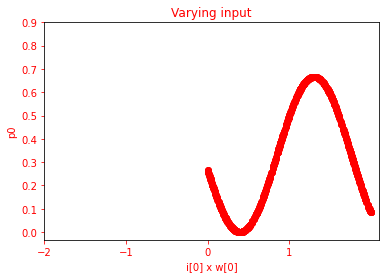

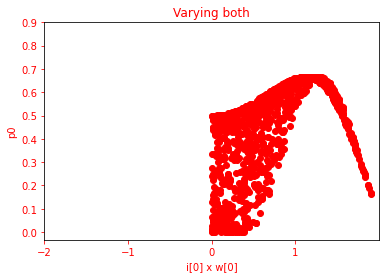

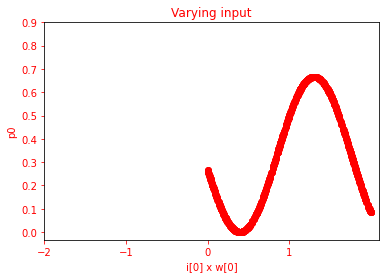

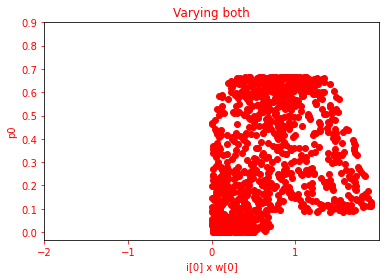

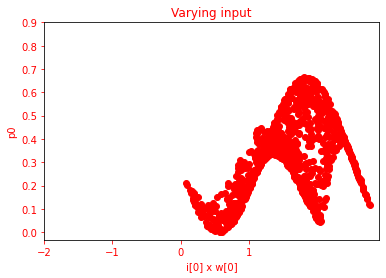

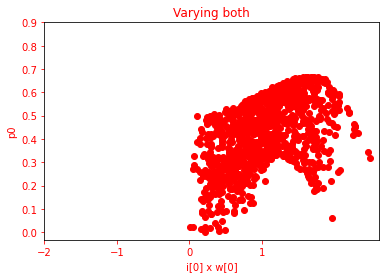

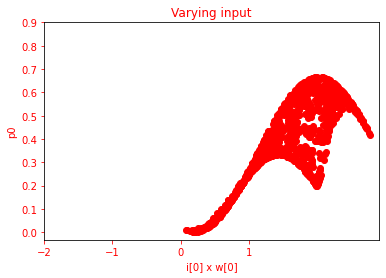

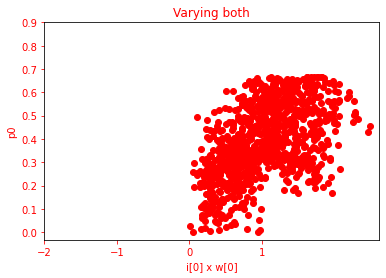

CPU times: user 4.72 s, sys: 168 ms, total: 4.89 s
Wall time: 4.96 s


In [13]:
%%time
# First let's see only what happens when we change what we're trying to vary
params = [1,1,1,0]# testar com valores [0,0,0,1], [0,0,1,1] ...
for variation in DIFFERENT_VARIATIONS:
    list_of_x, list_of_y, list_of_z = generate_many_points(1000, dimensions = 1, low=-1, high=1,varied_part=variation, normalizeX=False, normalizeW=False)
    plt.title("Varying " + variation, color = "red")
    plot_graph(list_of_x, list_of_y)

for variation in DIFFERENT_VARIATIONS:
    list_of_x, list_of_y, list_of_z = generate_many_points(1000, dimensions = 1, low=-1, high=1,varied_part=variation, normalizeX=True, normalizeW=False)
    plt.title("Varying " + variation, color = "red")
    plot_graph(list_of_x, list_of_y)
    
for variation in DIFFERENT_VARIATIONS:
    list_of_x, list_of_y, list_of_z = generate_many_points(1000, dimensions = 2, low=-1, high=1,varied_part=variation, normalizeX=False, normalizeW=False)
    plt.title("Varying " + variation, color = "red")
    plot_graph(list_of_x, list_of_y)

for variation in DIFFERENT_VARIATIONS:
    list_of_x, list_of_y, list_of_z = generate_many_points(1000, dimensions = 2, low=-1, high=1,varied_part=variation, normalizeX=True, normalizeW=False)
    plt.title("Varying " + variation, color = "red")
    plot_graph(list_of_x, list_of_y)

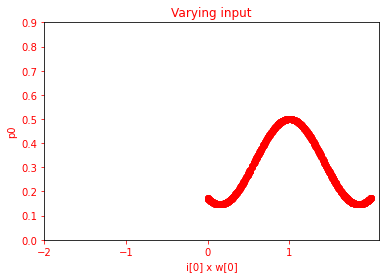

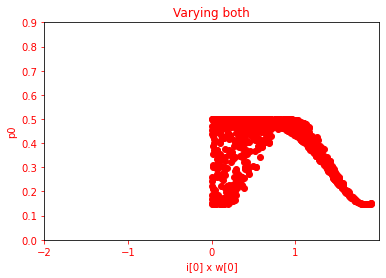

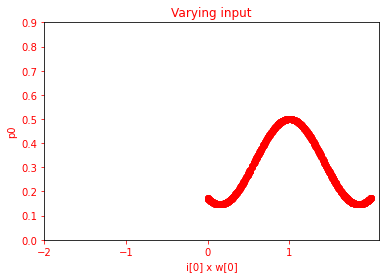

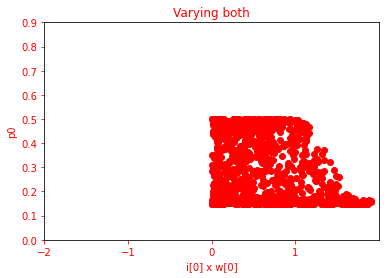

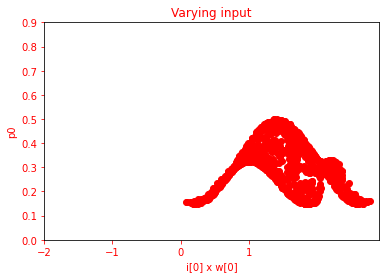

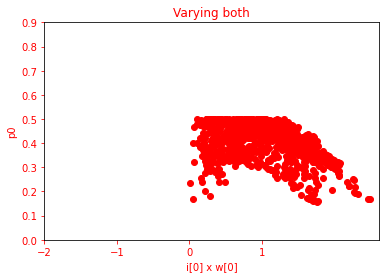

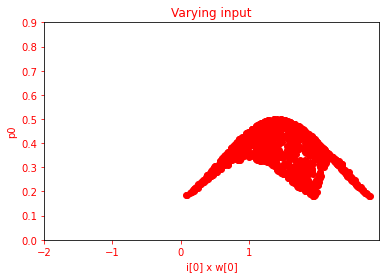

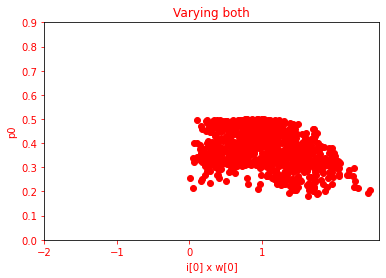

CPU times: user 5.19 s, sys: 206 ms, total: 5.39 s
Wall time: 5.54 s


In [14]:
%%time
# First let's see only what happens when we change what we're trying to vary
params = [1,0,0,1]# testar com valores [0,0,0,1], [0,0,1,1] ...
for variation in DIFFERENT_VARIATIONS:
    list_of_x, list_of_y, list_of_z = generate_many_points(1000, dimensions = 1, low=-1, high=1,varied_part=variation, normalizeX=False, normalizeW=False)
    plt.title("Varying " + variation, color = "red")
    plot_graph(list_of_x, list_of_y)

for variation in DIFFERENT_VARIATIONS:
    list_of_x, list_of_y, list_of_z = generate_many_points(1000, dimensions = 1, low=-1, high=1,varied_part=variation, normalizeX=True, normalizeW=False)
    plt.title("Varying " + variation, color = "red")
    plot_graph(list_of_x, list_of_y)
    
for variation in DIFFERENT_VARIATIONS:
    list_of_x, list_of_y, list_of_z = generate_many_points(1000, dimensions = 2, low=-1, high=1,varied_part=variation, normalizeX=False, normalizeW=False)
    plt.title("Varying " + variation, color = "red")
    plot_graph(list_of_x, list_of_y)

for variation in DIFFERENT_VARIATIONS:
    list_of_x, list_of_y, list_of_z = generate_many_points(1000, dimensions = 2, low=-1, high=1,varied_part=variation, normalizeX=True, normalizeW=False)
    plt.title("Varying " + variation, color = "red")
    plot_graph(list_of_x, list_of_y)

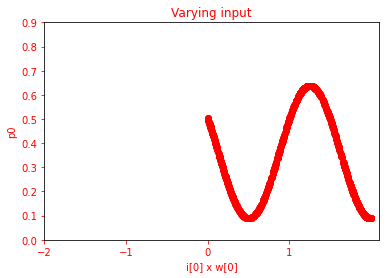

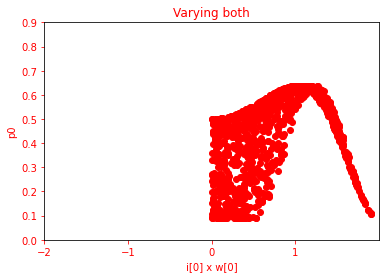

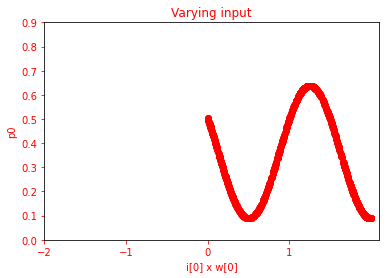

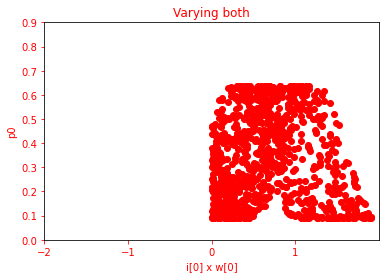

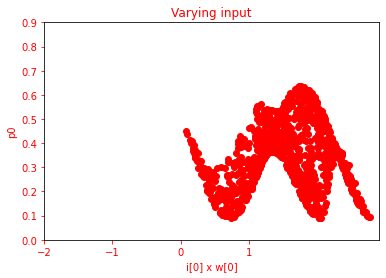

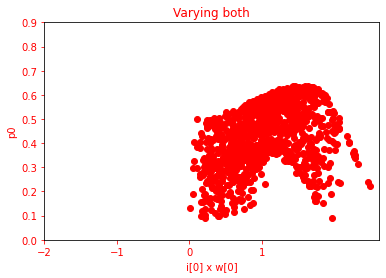

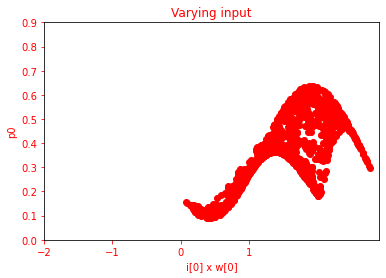

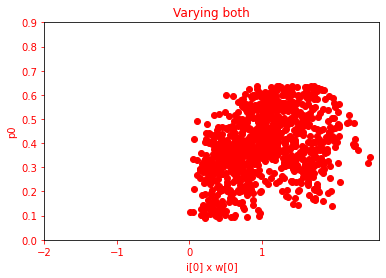

CPU times: user 4.83 s, sys: 174 ms, total: 5.01 s
Wall time: 5.09 s


In [15]:
%%time
# First let's see only what happens when we change what we're trying to vary
params = [1,1,0,1]# testar com valores [0,0,0,1], [0,0,1,1] ...
for variation in DIFFERENT_VARIATIONS:
    list_of_x, list_of_y, list_of_z = generate_many_points(1000, dimensions = 1, low=-1, high=1,varied_part=variation, normalizeX=False, normalizeW=False)
    plt.title("Varying " + variation, color = "red")
    plot_graph(list_of_x, list_of_y)

for variation in DIFFERENT_VARIATIONS:
    list_of_x, list_of_y, list_of_z = generate_many_points(1000, dimensions = 1, low=-1, high=1,varied_part=variation, normalizeX=True, normalizeW=False)
    plt.title("Varying " + variation, color = "red")
    plot_graph(list_of_x, list_of_y)
    
for variation in DIFFERENT_VARIATIONS:
    list_of_x, list_of_y, list_of_z = generate_many_points(1000, dimensions = 2, low=-1, high=1,varied_part=variation, normalizeX=False, normalizeW=False)
    plt.title("Varying " + variation, color = "red")
    plot_graph(list_of_x, list_of_y)

for variation in DIFFERENT_VARIATIONS:
    list_of_x, list_of_y, list_of_z = generate_many_points(1000, dimensions = 2, low=-1, high=1,varied_part=variation, normalizeX=True, normalizeW=False)
    plt.title("Varying " + variation, color = "red")
    plot_graph(list_of_x, list_of_y)

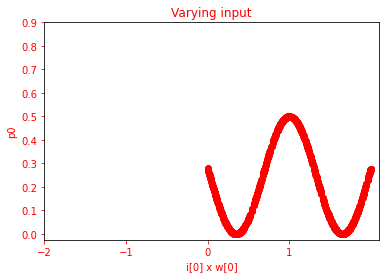

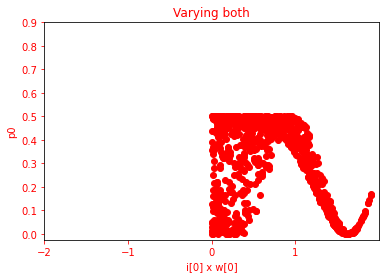

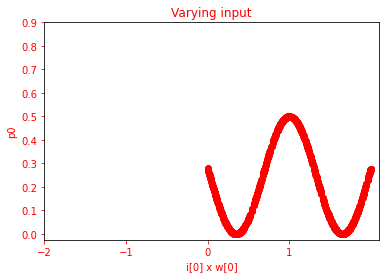

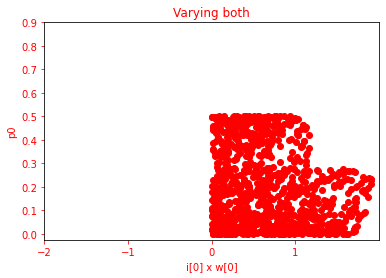

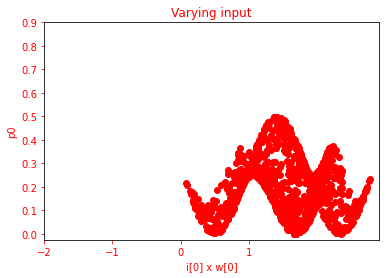

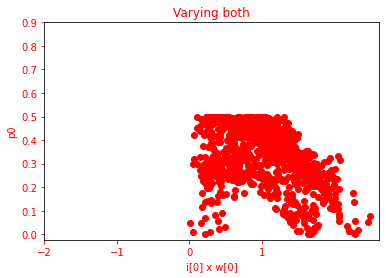

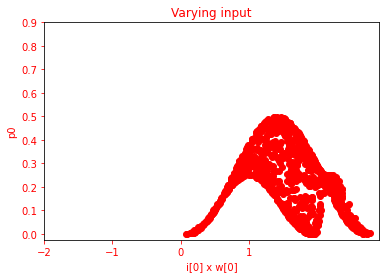

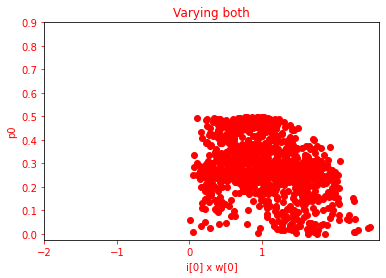

CPU times: user 4.11 s, sys: 127 ms, total: 4.24 s
Wall time: 4.27 s


In [17]:
%%time
# First let's see only what happens when we change what we're trying to vary
params = [1,0,1,1] 
for variation in DIFFERENT_VARIATIONS:
    list_of_x, list_of_y, list_of_z = generate_many_points(1000, dimensions = 1, low=-1, high=1,varied_part=variation, normalizeX=False, normalizeW=False)
    plt.title("Varying " + variation, color = "red")
    plot_graph(list_of_x, list_of_y)

for variation in DIFFERENT_VARIATIONS:
    list_of_x, list_of_y, list_of_z = generate_many_points(1000, dimensions = 1, low=-1, high=1,varied_part=variation, normalizeX=True, normalizeW=False)
    plt.title("Varying " + variation, color = "red")
    plot_graph(list_of_x, list_of_y)
    
for variation in DIFFERENT_VARIATIONS:
    list_of_x, list_of_y, list_of_z = generate_many_points(1000, dimensions = 2, low=-1, high=1,varied_part=variation, normalizeX=False, normalizeW=False)
    plt.title("Varying " + variation, color = "red")
    plot_graph(list_of_x, list_of_y)

for variation in DIFFERENT_VARIATIONS:
    list_of_x, list_of_y, list_of_z = generate_many_points(1000, dimensions = 2, low=-1, high=1,varied_part=variation, normalizeX=True, normalizeW=False)
    plt.title("Varying " + variation, color = "red")
    plot_graph(list_of_x, list_of_y)

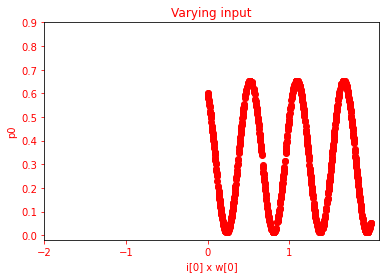

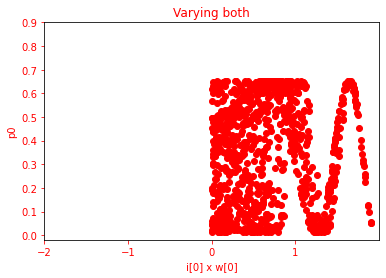

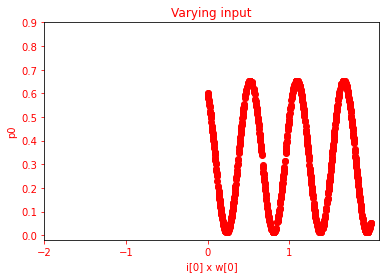

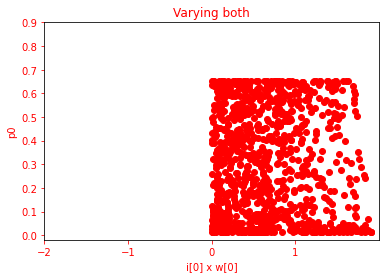

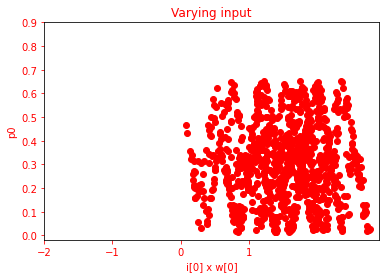

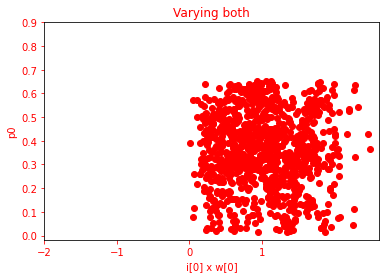

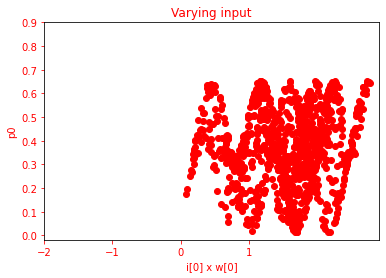

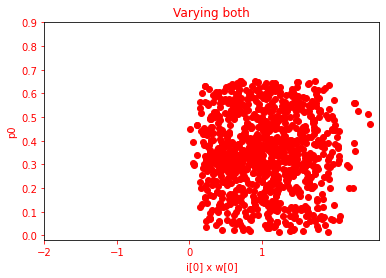

CPU times: user 5.54 s, sys: 202 ms, total: 5.74 s
Wall time: 5.85 s


In [16]:
%%time
# First let's see only what happens when we change what we're trying to vary
params = [2,3,3,1] 
for variation in DIFFERENT_VARIATIONS:
    list_of_x, list_of_y, list_of_z = generate_many_points(1000, dimensions = 1, low=-1, high=1,varied_part=variation, normalizeX=False, normalizeW=False)
    plt.title("Varying " + variation, color = "red")
    plot_graph(list_of_x, list_of_y)

for variation in DIFFERENT_VARIATIONS:
    list_of_x, list_of_y, list_of_z = generate_many_points(1000, dimensions = 1, low=-1, high=1,varied_part=variation, normalizeX=True, normalizeW=False)
    plt.title("Varying " + variation, color = "red")
    plot_graph(list_of_x, list_of_y)
    
for variation in DIFFERENT_VARIATIONS:
    list_of_x, list_of_y, list_of_z = generate_many_points(1000, dimensions = 2, low=-1, high=1,varied_part=variation, normalizeX=False, normalizeW=False)
    plt.title("Varying " + variation, color = "red")
    plot_graph(list_of_x, list_of_y)

for variation in DIFFERENT_VARIATIONS:
    list_of_x, list_of_y, list_of_z = generate_many_points(1000, dimensions = 2, low=-1, high=1,varied_part=variation, normalizeX=True, normalizeW=False)
    plt.title("Varying " + variation, color = "red")
    plot_graph(list_of_x, list_of_y)